In [2]:
import pandas as pd
import joblib
from pyecharts.charts import *
import pyecharts.options as opts
from sklearn.metrics import accuracy_score, precision_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.naive_bayes import BernoulliNB,GaussianNB,MultinomialNB
import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', None)

In [3]:
airlines_data_path = "./Airlines.csv"
airlines_data = pd.read_csv(airlines_data_path,index_col='id')

In [4]:
Xairline=airlines_data.loc[:,'Airline'].unique()
Xairline

array(['CO', 'US', 'AA', 'AS', 'DL', 'B6', 'HA', 'OO', '9E', 'OH', 'EV',
       'XE', 'YV', 'UA', 'MQ', 'FL', 'F9', 'WN'], dtype=object)

In [5]:
# ALCO = airlines_data[airlines_data['Airline']=='CO']
# Y_CO=len(ALCO[ALCO['Delay'] == 1 ])/len(ALCO)

airlines_data['Delay'].value_counts()


0    299119
1    240264
Name: Delay, dtype: int64

In [6]:
X=[]
Y=[]
for i in range(18):
    ALCO = airlines_data[airlines_data['Airline']== Xairline[i]]
    Y_CO=len(ALCO[ALCO['Delay'] == 1 ])/len(ALCO)
    X.append(Xairline[i-1])
    Y.append(Y_CO)

Text(0.5, 1.0, 'Delay of airline')

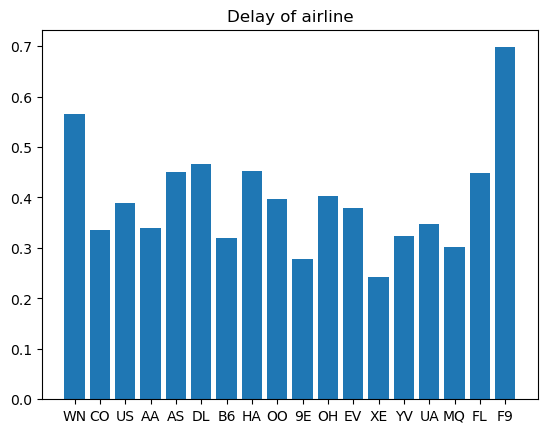

In [7]:
import matplotlib.pyplot as plt
plt.bar(X, Y, ls="-", lw=2)
plt.title('Delay of airline')

<class 'numpy.int64'>
<class 'float'>
<class 'numpy.int64'>
<class 'float'>
<class 'numpy.int64'>
<class 'float'>
<class 'numpy.int64'>
<class 'float'>
<class 'numpy.int64'>
<class 'float'>
<class 'numpy.int64'>
<class 'float'>
<class 'numpy.int64'>
<class 'float'>


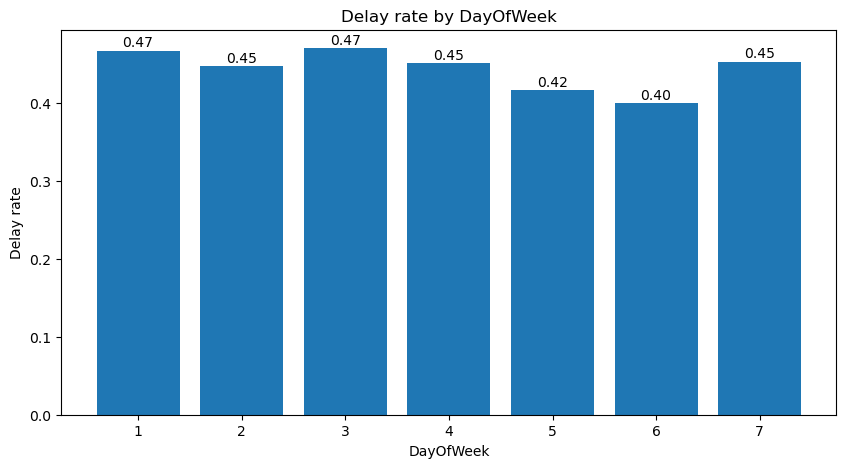

In [8]:
#calculate delay rate by DayOfWeek
x=[]
y=[]
DayOfWeek_unique=airlines_data.loc[:,'DayOfWeek'].unique()
for i in range(len(DayOfWeek_unique)):
    DayOfWeek_i=airlines_data[airlines_data['DayOfWeek']==DayOfWeek_unique[i-1]]
    delay_times=len(DayOfWeek_i[DayOfWeek_i['Delay']==1])
    delay_rate=delay_times/len(DayOfWeek_i)
    x.append(DayOfWeek_unique[i-1])
    y.append(delay_rate)
#sort by delay_rate and plt bar
tuple = zip(x,y)
tuple = sorted(tuple,key=lambda i:i[1],reverse=True)
x=[i[0] for i in tuple]
y=[i[1] for i in tuple]
plt.figure(figsize=(10,5))
plt.bar(x,y)
plt.title('Delay rate by DayOfWeek')
plt.xlabel('DayOfWeek')
plt.ylabel('Delay rate')
for a,b in zip(x,y):
    print(type(a))
    print(type(b))
    plt.text(a,b+0.01,'%.2f'%b,ha='center',va='center')
plt.show()

In [7]:
# 2.1 data content
airlines_data.head(5)

,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
id,,,,,,,,
1,CO,269,SFO,IAH,3,15,205,1
2,US,1558,PHX,CLT,3,15,222,1
3,AA,2400,LAX,DFW,3,20,165,1
4,AA,2466,SFO,DFW,3,20,195,1
5,AS,108,ANC,SEA,3,30,202,0


In [8]:
# 2.2 columns data type information
airlines_data.dtypes

Airline        object
Flight          int64
AirportFrom    object
AirportTo      object
DayOfWeek       int64
Time            int64
Length          int64
Delay           int64
dtype: object

In [9]:
# 2.3 statistics about numerical variables in data
airlines_data.describe()

,Flight,DayOfWeek,Time,Length,Delay
count,539383.000000,539383.000000,539383.000000,539383.000000,539383.000000
mean,2427.928630,3.929668,802.728963,132.202007,0.445442
std,2067.429837,1.914664,278.045911,70.117016,0.497015
min,1.000000,1.000000,10.000000,0.000000,0.000000
25%,712.000000,2.000000,565.000000,81.000000,0.000000
50%,1809.000000,4.000000,795.000000,115.000000,0.000000
75%,3745.000000,5.000000,1035.000000,162.000000,1.000000
max,7814.000000,7.000000,1439.000000,655.000000,1.000000


In [10]:
# 2.4 Missing data
airlines_data.isna().sum()  

Airline        0
Flight         0
AirportFrom    0
AirportTo      0
DayOfWeek      0
Time           0
Length         0
Delay          0
dtype: int64

In [11]:
# 2.5 Repeating data
airlines_data.duplicated().sum()  # It can be seen that there are a lot of duplicate data, but the original data has a unique id. 
# Considering that it should be the same route information at different times, no reprocessing is done.

216618

In [12]:
# 2.6 the distribution of statistical classification results
airlines_data['Delay'].value_counts()  # delay rate: 1
                                       # on time: 0

0    299119
1    240264
Name: Delay, dtype: int64

In [13]:
# 4.1 Replace day of week data (DayOfWeek) with weekday and weekend labels
airlines_data = airlines_data.join(pd.get_dummies(pd.cut(airlines_data['DayOfWeek'], [0, 5.5, 8], labels=['weekdays','weekend'])))
# 4.2 Replace route flight length data (Length) with short distance
airlines_data = airlines_data.join(pd.get_dummies(pd.cut(airlines_data['Length'], 3, labels=['Length_low','Length_mid','Length_high'])))
airlines_data = airlines_data.join(pd.get_dummies(pd.cut(airlines_data['Time'], [0, 360, 1080, 1440], labels=['Time1','Time2','Time3'])))
#  Sort by Airport

airlines_data['AirportFrom'] = airlines_data['AirportFrom'].astype(str)
temp_airline = airlines_data['AirportFrom'].unique()
label_encoder = LabelEncoder().fit(temp_airline)
temp_airline_label = label_encoder.transform(temp_airline)
airlines_data['AirportFrom'] = label_encoder.transform(airlines_data['AirportFrom'])


airlines_data['AirportTo'] = airlines_data['AirportTo'].astype(str)
temp_airline = airlines_data['AirportTo'].unique()
label_encoder = LabelEncoder().fit(temp_airline)
temp_airline_label = label_encoder.transform(temp_airline)
airlines_data['AirportTo'] = label_encoder.transform(airlines_data['AirportTo'])

# 4.3 Numericize the 'Airline' column data
airlines_data['Airline'] = airlines_data['Airline'].astype(str)
temp_airline = airlines_data['Airline'].unique()
label_encoder = LabelEncoder().fit(temp_airline)
temp_airline_label = label_encoder.transform(temp_airline)
airlines_data['Airline'] = label_encoder.transform(airlines_data['Airline'])
# 4.4 Obtain the data required for model training and testing
X_d = airlines_data.loc[:,['Airline','AirportFrom','AirportTo','weekdays','Time','Length']]
y_d = airlines_data.loc[:,'Delay']
# 4.5 Extract training data and test data
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_d, y_d, test_size=0.2, random_state=2)

In [14]:

model_details = []
def modle_pro(modle_):
    
    modle_d_list = []
    
    modle = modle_
    
    old_time = time.time()
    modle.fit(X_train_d,y_train_d)
    current_time = time.time()
    use_time = round(current_time-old_time,4)
   
    pre = modle.predict(X_test_d)
    pre = pre.astype(np.int64)
   
    precision = round(accuracy_score(pre,y_test_d),4)
    modle_d_list.append(str(modle_))
    modle_d_list.append(use_time)
    modle_d_list.append(precision)
    model_details.append(modle_d_list)

gnb = GaussianNB()
modle_pro(gnb)


bnb = BernoulliNB()
modle_pro(bnb)

mnb = MultinomialNB()
modle_pro(mnb)

knn = KNeighborsClassifier(n_neighbors=3)
modle_pro(knn)

lr = LinearRegression()
modle_pro(lr)

lgr = LogisticRegression()
modle_pro(lgr)

dtc_e = DecisionTreeClassifier(criterion='entropy')
modle_pro(dtc_e)
dtc_g = DecisionTreeClassifier(criterion='gini',max_depth=20)
modle_pro(dtc_g)

rfc = RandomForestClassifier()
modle_pro(rfc)
df = pd.DataFrame(model_details, columns=['modle_name', 'use_time', 'accuracy_score'])
df.sort_values('accuracy_score',ascending=False)

,modle_name,use_time,accuracy_score
7,DecisionTreeClassifier(max_depth=20),0.8440,0.6550
6,DecisionTreeClassifier(criterion='entropy'),1.0302,0.6527
8,RandomForestClassifier(),30.0147,0.6526
3,KNeighborsClassifier(n_neighbors=3),0.5867,0.6304
0,GaussianNB(),0.0688,0.5802
5,LogisticRegression(),1.7282,0.5793
1,BernoulliNB(),0.0758,0.5555
4,LinearRegression(),0.0286,0.5555
2,MultinomialNB(),0.0609,0.5288


In [15]:
knn = KNeighborsClassifier(n_neighbors=2)
modle_pro(knn)

In [16]:
pre = knn.predict(X_test_d)

In [17]:
len(pre)

107877

In [21]:
#保存训练的模型
joblib.dump(knn, "./test.pkl")

['./test.pkl']